In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.font_manager

In [2]:
#缓存（cache）装饰器
from requests import get
from functools import wraps

def check_cache(f):
    @wraps(f)
    def wrapper(src:str, dst:str, min_size=100) -> Path:
        if src.find('?') == -1:
            url = Path(src)
        else:
            url = Path(src[:src.find('?')])
        fn  = url.name  # Extract the filename
        dsn = Path(f"{dst}/{fn}") # Destination filename
        if dsn.is_file() and dsn.stat().st_size > min_size:
            print(f"+ {dsn} found locally!")
            return(dsn)
        else:
            print(f"+ {dsn} not found, downloading!")
            return(f(src, dsn))
    return wrapper

In [3]:
#下载函数
@check_cache
def cache_data(src:Path, dst:Path) -> str:
    """Downloads a remote file.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dst : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
      
    # Create any missing directories in dest(ination) path
    # -- os.path.join is the reverse of split (as you saw above)
    # but it doesn't work with lists... so I had to google how
    # to use the 'splat' operator! os.makedirs creates missing
    # directories in a path automatically.
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True, exist_ok=True)
        
    # Download and write the file
    with dst.open(mode='wb') as file:
        response = get(src)
        file.write(response.content)
        
    print(' + Done downloading...')

    return dst.resolve()

In [4]:
help(cache_data)

Help on function cache_data in module __main__:

cache_data(src: pathlib.Path, dst: pathlib.Path) -> str
    Downloads a remote file.

    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.

    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dst : str
        The *destination* location to save the downloaded file.

    Returns
    -------
    str
        A string representing the local location of the file.



In [5]:
#下载/读取地理数据
ddir  = Path('data/geo')
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path

boros = gpd.read_file( cache_data(spath + 'Boroughs.gpkg?raw=true', ddir.resolve()) )

print('Done.')

+ /home/jovyan/work/The-Universe-s-Premier-F/data/geo/Boroughs.gpkg not found, downloading!
 + Done downloading...
Done.


In [6]:
# Input: date + city
ymd  = '20250615'
city = 'London'
host = "https://raw.githubusercontent.com"
repo = "yjzhou217/The-Universe-s-Premier-F/main"

url  = f"{host}/{repo}/{ymd}-{city}-listings.csv.gz"
print(url)

# 创建 data/raw 文件夹
Path("data/raw").mkdir(parents=True, exist_ok=True)

# load csv
file_path = cache_data(url, Path("data/raw").resolve())

df = pd.read_csv(file_path, compression="gzip", low_memory=False)
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")


https://raw.githubusercontent.com/yjzhou217/The-Universe-s-Premier-F/main/20250615-London-listings.csv.gz
+ /home/jovyan/work/The-Universe-s-Premier-F/data/raw/20250615-London-listings.csv.gz found locally!
Data frame is 96,651 x 79


In [7]:
#clean csv data
#testing mode
TESTING = False

if TESTING:
    N = 10_000
else:
    N = None  # None = read all

df = pd.read_csv(
    file_path,
    nrows=N,
    low_memory=False
)

print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 96,651 x 79


In [8]:
#随机抽样
df.sample(3, random_state=42)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
55322,940318502107598761,https://www.airbnb.com/rooms/940318502107598761,20250610032232,2025-06-12,city scrape,Lovely flat in West London,Calm and tranquil flat just off Portobello Roa...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,12260283,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
82794,1316092340060307099,https://www.airbnb.com/rooms/1316092340060307099,20250610032232,2025-06-14,previous scrape,Short walk from local amenities,Keep it simple at this peaceful and centrally-...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,667965836,...,NaN,NaN,NaN,NaN,t,1,0,1,0,NaN
21163,25321683,https://www.airbnb.com/rooms/25321683,20250610032232,2025-06-13,previous scrape,"Bright, modern flat near Finsbury Park","Light, modern 1-bedroom flat situated next to ...",NaN,https://a0.muscache.com/pictures/ff89be9e-bced...,5768769,...,5.0,5.0,5.0,NaN,t,1,1,0,0,0.01


In [9]:
#clean data
#删除id缺失的行
missing_id_rows = df[df['id'].isna()][['id', "latitude", "longitude", 'room_type']]
print(f"{missing_id_rows.shape[0]:,}")
if missing_id_rows.shape[0] > 0:
    print(missing_id_rows.head())

df.drop(df[df['id'].isna()].index, axis=0, inplace=True)
print(f"{df.shape[0]:,} x {df.shape[1]}")

0
96,651 x 79


In [10]:
#寻找垃圾列
df.isnull().sum(axis=0).sort_values(ascending=False)[:12]

license                         96651
calendar_updated                96651
neighbourhood_group_cleansed    96651
neighborhood_overview           54668
neighbourhood                   54667
host_neighbourhood              50360
host_about                      47337
beds                            33975
price                           33967
estimated_revenue_l365d         33967
bathrooms                       33921
host_response_rate              33024
dtype: int64

In [11]:
#删除全是nan的列
df.drop(columns=['license','calendar_updated','neighbourhood_group_cleansed'], inplace=True)

In [12]:
#寻找垃圾行
df.isnull().sum(axis=1).sort_values(ascending=False).head(10)

5155     33
6122     33
4622     33
3646     32
5535     31
30641    31
58822    28
86012    27
89683    27
87970    27
dtype: int64

<class 'pandas.core.series.Series'>


<Axes: ylabel='Frequency'>

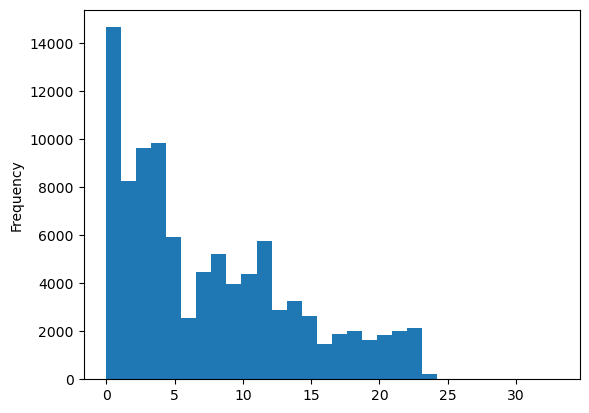

In [13]:
#绘制 histogram
probs = df.isnull().sum(axis=1)
print(type(probs))
probs.plot.hist(bins=30)

In [14]:
#考虑删除缺失超过25个值的行
print(f"df contains {df.shape[0]:,} rows.")
cutoff = 25
df.drop(probs[probs > cutoff].index, inplace=True)
print(f"df contains {df.shape[0]:,} rows.")

df contains 96,651 rows.
df contains 96,639 rows.


In [15]:
#Fixing Data Types
#把分类变量变成category，包括source、property_type、room_type、neighbourhood、neighbourhood_cleansed、host_response_time
cols_to_category = [
    'source', 'property_type', 'room_type',
    'neighbourhood', 'neighbourhood_cleansed',
    'host_response_time'
]

for col in cols_to_category:
    df[col] = df[col].astype('category')

#字符串布尔变成Boolean
bool_cols = [
    'host_has_profile_pic',
    'host_identity_verified',
    'host_is_superhost',
    'has_availability',
    'instant_bookable'
]

for col in bool_cols:
    df[col] = df[col].replace({'t': True, 'f': False}).astype(bool)

#转换日期格式
date_cols = [
    'host_since',
    'last_scraped',
    'calendar_last_scraped',
    'first_review',
    'last_review'          
]

for col in date_cols:
    df[col] = pd.to_datetime(df[col])

#Dealing with Strings（price）
money = ['price']
for m in money:
    df[m] = df[m].str.replace('$','', regex=False).str.replace(',','', regex=False).astype('float')

#Dealing with Integers（处理整数列）
int_cols = [
    'id', 'host_id', 'host_listings_count', 'host_total_listings_count',
    'accommodates', 'beds', 'bedrooms', 'minimum_nights', 'maximum_nights',
    'availability_30','availability_60','availability_90','availability_365',
    'number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','number_of_reviews_ly'
]

for col in int_cols:
    print(f"Converting {col}")
    try:
        df[col] = df[col].astype('float').astype('int')
    except ValueError as e:
        print(f"  - Warning: {col} has missing or non-integer values, converting to nullable UInt16")
        df[col] = df[col].astype('float').astype(pd.UInt16Dtype())

Converting id
Converting host_id
Converting host_listings_count
  - Warning: host_listings_count has missing or non-integer values, converting to nullable UInt16
Converting host_total_listings_count
  - Warning: host_total_listings_count has missing or non-integer values, converting to nullable UInt16
Converting accommodates
Converting beds
  - Warning: beds has missing or non-integer values, converting to nullable UInt16
Converting bedrooms
  - Warning: bedrooms has missing or non-integer values, converting to nullable UInt16
Converting minimum_nights
Converting maximum_nights
Converting availability_30
Converting availability_60
Converting availability_90
Converting availability_365
Converting number_of_reviews
Converting number_of_reviews_ltm
Converting number_of_reviews_l30d
Converting number_of_reviews_ly


/tmp/ipykernel_145819/1744722621.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'t': True, 'f': False}).astype(bool)


In [16]:
#Validation
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96639 entries, 0 to 96650
Data columns (total 76 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            96639 non-null  int64         
 1   listing_url                                   96639 non-null  object        
 2   scrape_id                                     96639 non-null  int64         
 3   last_scraped                                  96639 non-null  datetime64[ns]
 4   source                                        96639 non-null  category      
 5   name                                          96639 non-null  object        
 6   description                                   93794 non-null  object        
 7   neighborhood_overview                         41982 non-null  object        
 8   picture_url                                   96630 non-null  object   

In [17]:
#Saving
from pathlib import Path

# 输出文件路径
csv_out = Path(f"data/clean/{file_path.name}") 
pq_out  = Path(f"data/clean/{file_path.name.replace('.csv.gz','.parquet')}")

# 创建文件夹（如果不存在）
if not csv_out.parent.exists():
    print(f"Creating folder {csv_out.parent}")
    csv_out.parent.mkdir(parents=True, exist_ok=True)

# 保存 CSV 和 Parquet
df.to_csv(csv_out, index=False)
df.to_parquet(pq_out, index=False)

print(f"Saved {df.shape[0]:,} rows of {df.shape[1]} columns to {csv_out.resolve()}")
print("Done.")

Saved 96,639 rows of 76 columns to /home/jovyan/work/The-Universe-s-Premier-F/data/clean/20250615-London-listings.csv.gz
Done.


In [18]:
#导入clean完的Parquet
parquet_path = Path("data/clean") / file_path.name.replace(".csv.gz", ".parquet")
df = pd.read_parquet(parquet_path)
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 96,639 x 76


In [19]:
#从 DataFrame 创建 GeoDataFrame（把 lon/lat 转为 geometry）
gdf = gpd.GeoDataFrame(df,
      geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))

In [20]:
#保存 geo parquet
gdf.to_parquet(Path(f'data/geo/{ymd}-{city}-listings.geoparquet').resolve())
print(type(gdf))
print(type(gdf.geometry))
gdf.geometry.iloc[1:5]

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>


1    POINT (-0.01997 51.44284)
2    POINT (-0.02275 51.44359)
3    POINT (-0.02309 51.44355)
4    POINT (-0.02307 51.44333)
Name: geometry, dtype: geometry